In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

## Ignoring Warning during trainings 
import warnings
warnings.filterwarnings('ignore')
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
file_path = "/content/drive/MyDrive/train.csv"
raw_data = pd.read_csv(file_path)
print("Data points count: ", raw_data['id'].count())
raw_data.head()


Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
ax = raw_data['target'].value_counts()
print(ax)

0    4342
1    3271
Name: target, dtype: int64


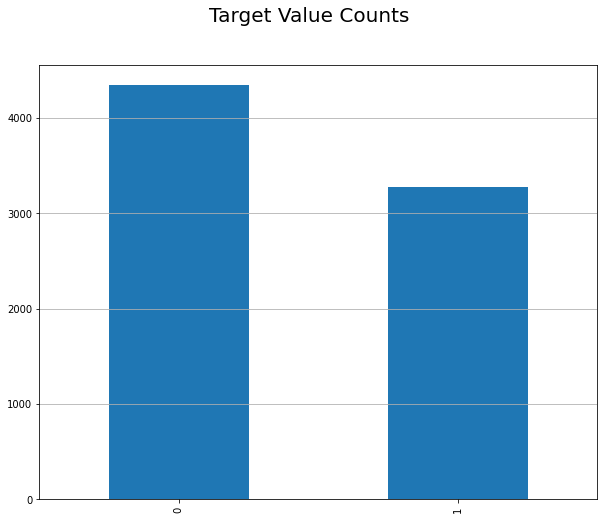

In [8]:
plt.figure(figsize=(10,8))
ax = raw_data['target'].value_counts().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()


***We have more data for target=0, than target=1, which means more tweets do not correspond to disaster occuring.***

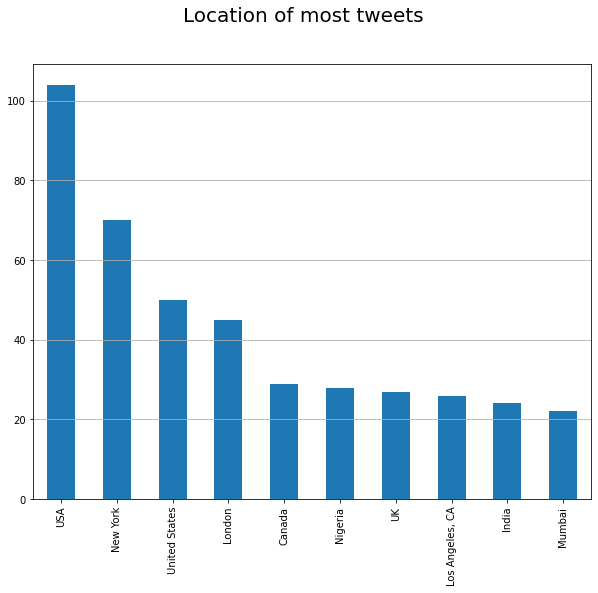

In [41]:
plt.figure(figsize=(10,8))
ax = raw_data['location'].value_counts()[:10].plot(kind="bar")   # Most tweets location
ax.grid(axis="y")
plt.suptitle("Location of most tweets", fontsize=20)
plt.show()

***Most tweets are from US followed by London and Canada.***

In [10]:
print("Number of missing data for column keyword: ", raw_data['keyword'].isna().sum())
print("Number of missing data for column location: ", raw_data['location'].isna().sum())
print("Number of missing data for column text: ", raw_data['text'].isna().sum())
print("Number of missing data for column target: ", raw_data['target'].isna().sum())


Number of missing data for column keyword:  61
Number of missing data for column location:  2533
Number of missing data for column text:  0
Number of missing data for column target:  0


***We have many missing values for location. Also we cannot simply use nan replacement as it might not be very useful. So we will drop the column.***

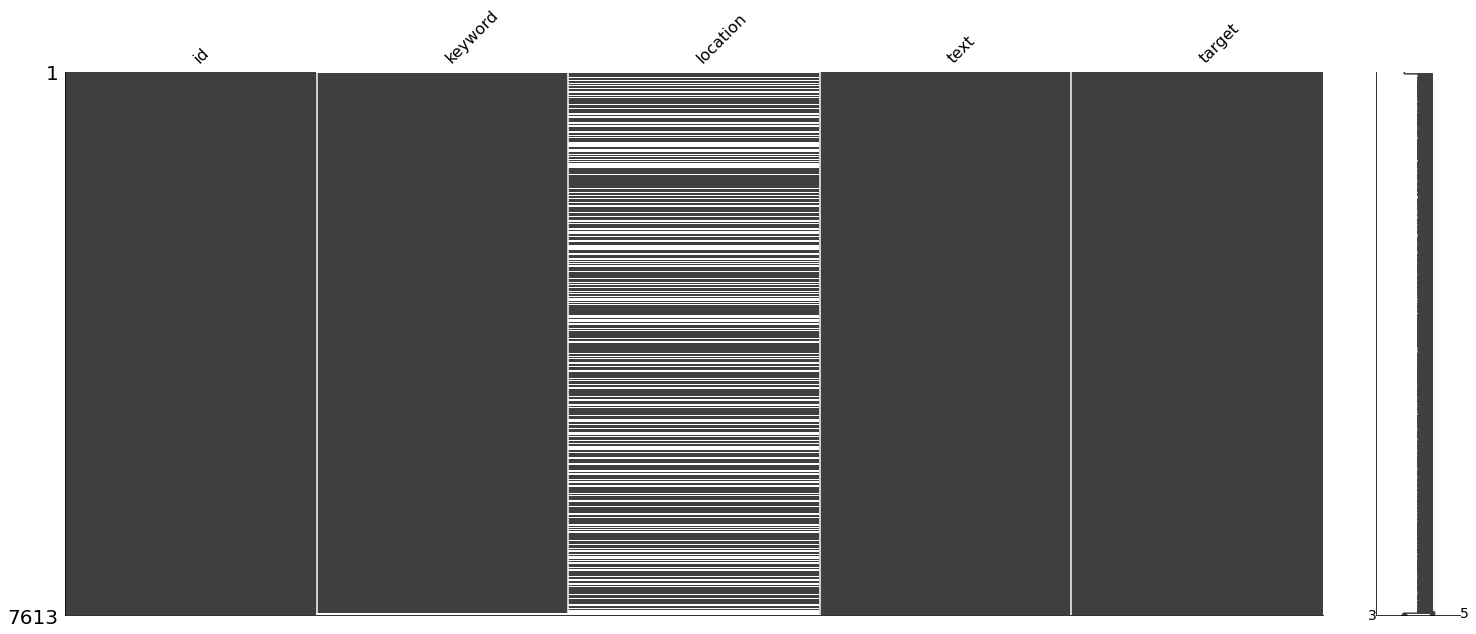

In [13]:
import missingno as miss                    #www.github.com
miss.matrix(raw_data)
sns.despine()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


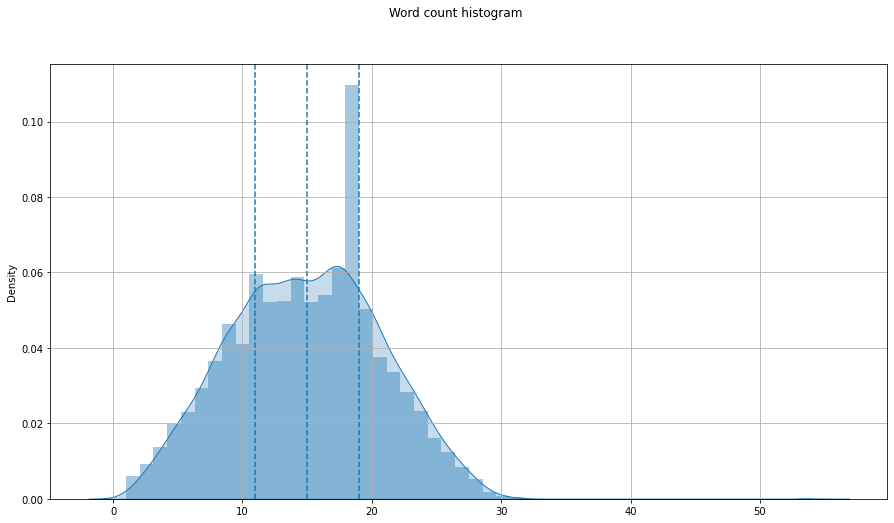

In [14]:
plt.figure(figsize=(15,8))                            #www.github.com
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(raw_data['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(raw_data['word_count'].describe()['25%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['50%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()

# remove rows with under 3 words since <2 words tweets don't give much information.
raw_data = raw_data[raw_data['word_count']>2]  
raw_data = raw_data.reset_index()


In [15]:
print("25th percentile: ", raw_data['word_count'].describe()['25%'])
print("mean: ", raw_data['word_count'].describe()['50%'])
print("75th percentile: ", raw_data['word_count'].describe()['75%'])


25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


***Most tweets contain 15 words. Less than 25% of tweets have more than 19 words.***

Text(0.5, 1.0, 'Most common keywords')

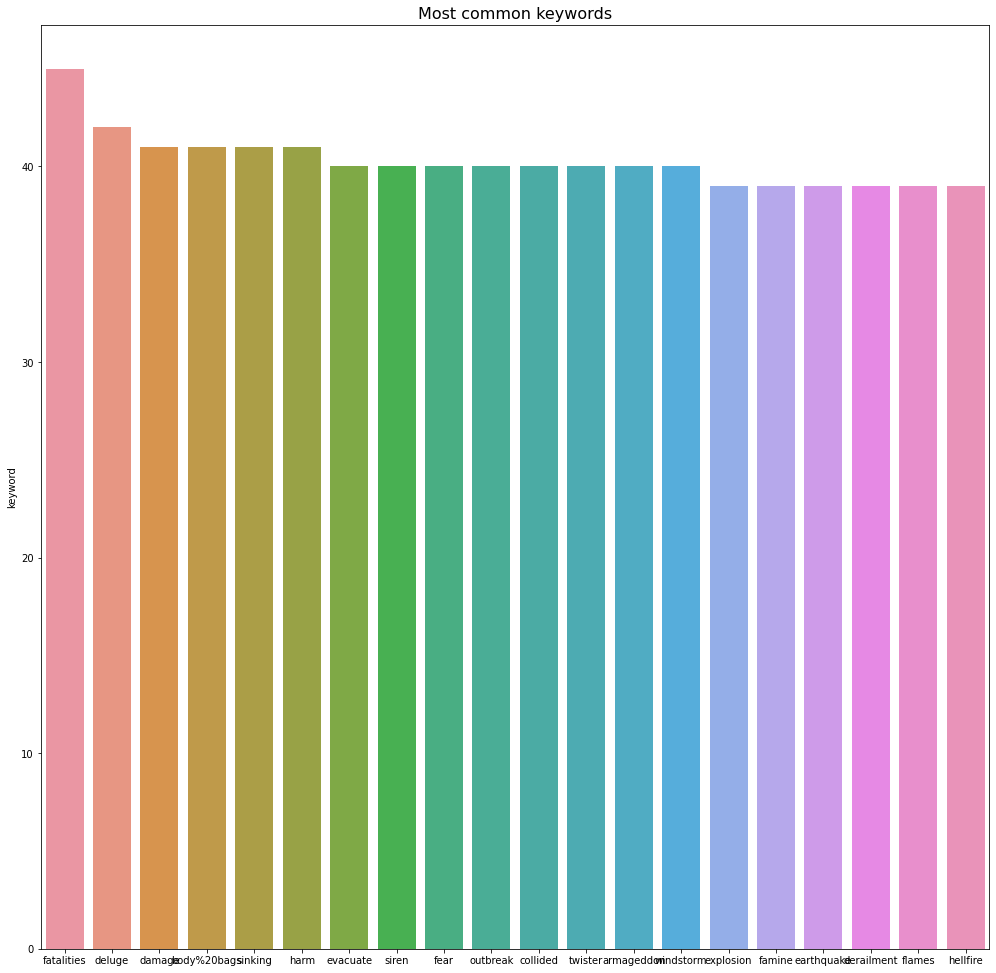

In [26]:
common_keywords=raw_data["keyword"].value_counts()[:20].to_frame()
fig=plt.figure(figsize=(17,17))
sns.barplot(data=common_keywords,x=common_keywords.index,y="keyword")
plt.title("Most common keywords",size=16)

In [27]:
raw_data["keyword"].value_counts()

fatalities               45
deluge                   42
damage                   41
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

***Most common keywords used are  fatalities, deluge, damage,sinking etc.***

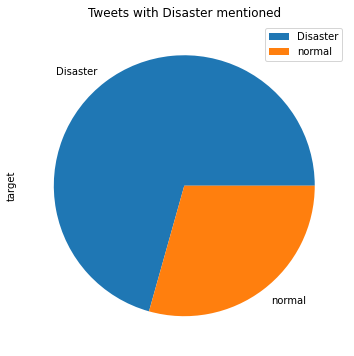

In [29]:
raw_data[raw_data.text.str.contains("disaster")].target.\
 value_counts().to_frame().rename(index={1:"Disaster",0:"normal"}).\
  plot.pie(y="target",figsize=(12,6),title="Tweets with Disaster mentioned");

***Majority of tweets containing disaster, actually corresponded to real catastrophe.***

Text(0.5, 1.0, 'Non Disaster Tweets')

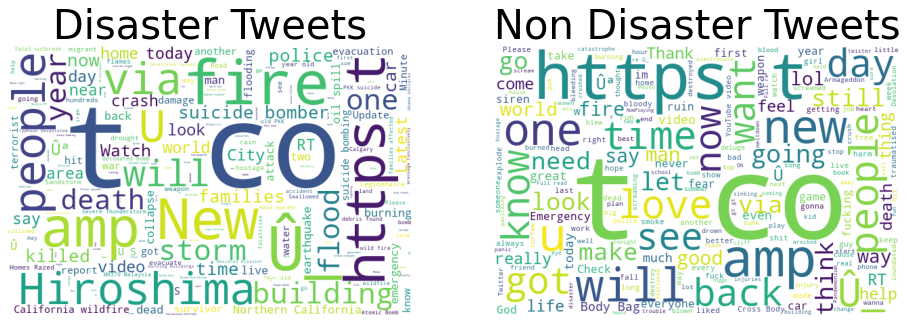

In [36]:
disaster_tweets = raw_data[raw_data['target']==1]['text']
non_disaster_tweets = raw_data[raw_data['target']==0]['text']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40)

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40)